<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-data" data-toc-modified-id="Load-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load data</a></span></li><li><span><a href="#Data-Growth" data-toc-modified-id="Data-Growth-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Growth</a></span></li><li><span><a href="#Hierarchical-Clustering" data-toc-modified-id="Hierarchical-Clustering-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Hierarchical Clustering</a></span></li><li><span><a href="#PCA" data-toc-modified-id="PCA-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>PCA</a></span></li><li><span><a href="#Normalize-to-reference-conditions" data-toc-modified-id="Normalize-to-reference-conditions-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Normalize to reference conditions</a></span></li></ul></div>

<font size="4">This is a template notebook for exploratory analysis on your organism's QC'ed dataset.</font>

In [49]:
import pandas as pd
import os
from os import path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [50]:
sns.set_style('ticks')

# Load data

In [51]:
organism = "Synechococcus_elongatus"

In [52]:
org_dir = path.join('/home/tahani/Documents/github/modulome/data/organisms/',organism)
os.listdir(org_dir)

['1_log_tpm_final.csv',
 '.~lock.metadata_curated_non_project_spec.csv#',
 '.~lock.metadata_curated_project_spec.csv#',
 'README.md',
 'metadata_curated_project_spec.csv',
 '0_log_tpm.csv',
 '0_multiqc_stats.tsv',
 'metadata_curated_non_project_spec.csv',
 '1_metadata_final.csv',
 'metadata_passed_qc_part1.csv',
 '0_Synechococcus_elongatus.tsv',
 '0_multiqc_report.html',
 'Excel_files',
 'sequence_files']

In [53]:
DF_metadata = pd.read_csv(os.path.join(org_dir,'1_metadata_final.csv'),index_col=0)
DF_log_tpm = pd.read_csv(os.path.join(org_dir,'1_log_tpm_final.csv'),index_col=0)

# Data Growth

In [54]:
DF_metadata['ReleaseDate'] = pd.to_datetime(DF_metadata['ReleaseDate'])

In [55]:
first_date = min(DF_metadata['ReleaseDate'])
last_date = max(DF_metadata['ReleaseDate'])
date_range = pd.date_range(start=first_date,end=last_date,freq='YS')

Text(0, 0.5, 'Number of Samples')

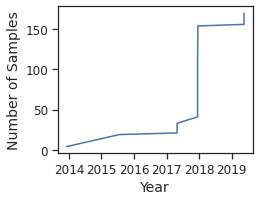

In [56]:
fig,ax = plt.subplots(figsize=(3.5,3))
growth = DF_metadata['ReleaseDate'].value_counts().sort_index().cumsum()
growth.plot(ax=ax)
plt.xticks(date_range,date_range.strftime('%Y'),rotation=0,ha='center')
ax.tick_params(labelsize=12)
ax.set_xlabel('Year',fontsize=14)
ax.set_ylabel('Number of Samples',fontsize=14)

# Hierarchical Clustering

<font size=4> A clustermap is a great way to visualize the global correlations between one sample and all others. The following code uses hierarchical clustering to identify specific clusters in the clustermap <font size=4>
    
<font size=4> To increase the number of clusters, decrease the value of `thresh`. To decrease the number of clusters, increase the value of `thresh` <font size=4>

In [57]:
import scipy.cluster.hierarchy as sch
import matplotlib.patches as patches
# change this to get different number of clusters
thresh = .4

# retrieve clusters using fcluster 
corr = DF_log_tpm.corr()
corr.fillna(0,inplace=True)
dist = sch.distance.pdist(corr)
link = sch.linkage(dist, method='complete')
clst = pd.DataFrame(index=DF_log_tpm.columns)
clst['cluster'] = sch.fcluster(link, thresh * dist.max(), 'distance')

#get colors for each cluster
cm = plt.cm.get_cmap('tab20')
clr = dict(zip(clst.cluster.unique(), cm.colors))
clst['color'] = clst.cluster.map(clr)

print('Number of cluster: ', len(clr))

Number of cluster:  8


<font size="4">To view sample IDs in the clustermap, set `xticklabels` and `yticklabels` to `True`. You can increase the `size` variable to improve readability of sample IDs<font>

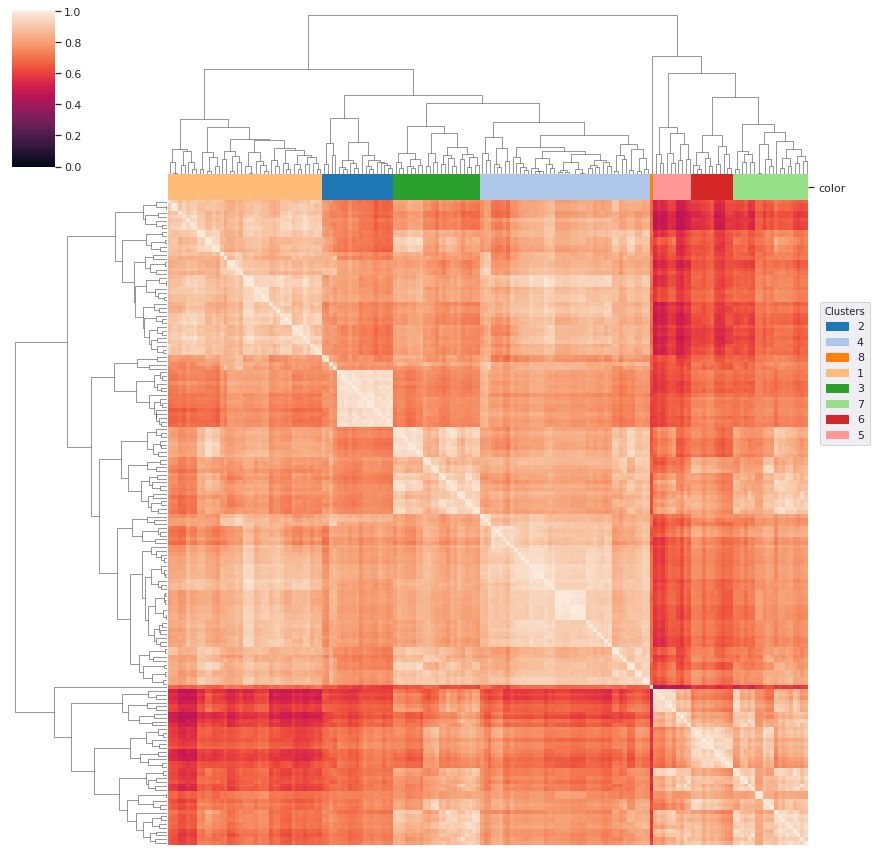

In [58]:
size = 12

legend_TN = [patches.Patch(color=c, label=l) for l,c in clr.items()]

sns.set(rc={'figure.facecolor':'white'})
g = sns.clustermap(DF_log_tpm.corr(), figsize=(size,size), 
                   row_linkage=link, col_linkage=link, col_colors=clst.color,
                  yticklabels=False, xticklabels=False, vmin=0, vmax=1)

l2=g.ax_heatmap.legend(loc='upper left', bbox_to_anchor=(1.01,0.85), handles=legend_TN,frameon=True)
l2.set_title(title='Clusters',prop={'size':10})

# PCA

In [59]:
from sklearn.decomposition import PCA
import numpy as np

<font size="4"> First compute principal components.</font>

In [60]:
pca = PCA()
DF_weights = pd.DataFrame(pca.fit_transform(DF_log_tpm.T),index=DF_log_tpm.columns)
DF_components = pd.DataFrame(pca.components_.T,index=DF_log_tpm.index)

<font size="4"> Next, plot the cumulative explained variance</font>

Number of dimensions for 99% of variance: 103


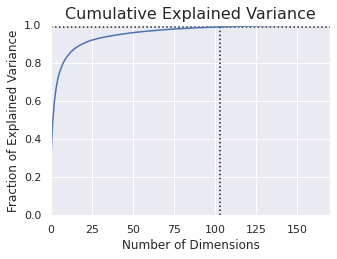

In [61]:
# Set the explained variance threshold
var_cutoff = 0.99

fig,ax = plt.subplots(figsize=(5,3.5))
pca_var = np.cumsum(pca.explained_variance_ratio_)
ax.plot(pca_var)
dims = np.where(pca_var > var_cutoff)[0][0] + 1
ax.vlines(dims,0,1,linestyles='dotted')
ax.hlines(var_cutoff,0,len(DF_log_tpm.columns),linestyles='dotted')
ax.set_ylim(0,1)
ax.set_xlim(0,len(DF_log_tpm.columns))
ax.set_ylabel('Fraction of Explained Variance',fontsize=12)
ax.set_xlabel('Number of Dimensions',fontsize=12)
ax.set_title('Cumulative Explained Variance',fontsize=16)
print('Number of dimensions for 99% of variance:',dims)

<font size="4">Finally, plot the first two principle components. The following code colors data by Project Name.</font>

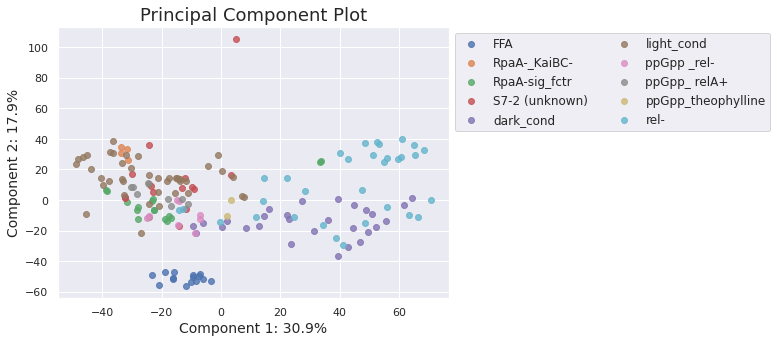

In [62]:
fig,ax = plt.subplots(figsize=(7,5))
for name,group in DF_metadata.groupby('project_name'):
    idx = DF_log_tpm.loc[:,group.index.tolist()].columns.tolist()
    ax.scatter(DF_weights.loc[idx,0],
               DF_weights.loc[idx,1],
               label=name,alpha=0.8)
ax.set_xlabel('Component 1: %.1f%%'%(pca.explained_variance_ratio_[0]*100),fontsize=14)
ax.set_ylabel('Component 2: %.1f%%'%(pca.explained_variance_ratio_[1]*100),fontsize=14)
ax.set_title('Principal Component Plot',fontsize=18)
plt.legend(bbox_to_anchor=(1,1),fontsize=12,ncol=2)

# Normalize to reference conditions

In [63]:
DF_metadata.project_name

SRX259777               FFA
SRX259778               FFA
SRX259779               FFA
SRX259780               FFA
SRX259781               FFA
                  ...      
SRX4105539    RpaA-sig_fctr
SRX4105557    RpaA-sig_fctr
SRX4105558    RpaA-sig_fctr
SRX4105564    RpaA-sig_fctr
SRX4105565    RpaA-sig_fctr
Name: project_name, Length: 170, dtype: object

In [69]:
project_exprs = []
for name,group in DF_metadata.groupby('project_name'):
    ref_cond = group.reference_sample.unique()
    
    # Ensure that there is only one reference condition per project
    assert(len(ref_cond) == 1)
    ref_cond = ref_cond[0]
    
    # Ensure the reference condition is in fact in the project
    #assert(ref_cond in group.condition_name.tolist())
    
    # Get reference condition sample ids
    ref_samples = group[group.condition_name == ref_cond].index
    
    # Get reference condition expression
    ref_expr = DF_log_tpm[ref_samples].mean(axis=1)
    
    # Subtract reference expression from project
    project_exprs.append(DF_log_tpm[group.index].sub(ref_expr,axis=0))

DF_log_tpm_norm = pd.concat(project_exprs,axis=1)

In [70]:
DF_log_tpm_norm.head()

,SRX259777,SRX259778,SRX259779,SRX259780,SRX259781,SRX259782,SRX259783,SRX259784,SRX259785,SRX259786,...,SRX3176804,SRX3176805,SRX3176806,SRX3176808,SRX3176809,SRX3176810,SRX3176811,SRX3176812,SRX3176813,SRX3176814
Synonym,,,,,,,,,,,,,,,,,,,,,
ST32046_p9_1,-0.403940,0.497148,-0.093208,-0.455346,-0.954072,-0.012703,-0.335489,0.047725,0.019656,-0.361624,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ST32046_p4,-0.288124,0.419910,-0.131786,0.317495,-0.221662,0.552705,-0.371249,0.046427,-0.058619,-0.014579,...,-0.284825,0.064882,-0.453033,-0.157389,-0.492058,-0.568384,0.029798,0.083987,-0.191670,-0.419455
ST32046_p5,-0.423393,0.177337,0.246056,-0.138804,-0.194244,0.053751,-0.309271,-0.228610,-0.409483,-0.497118,...,1.382564,0.072250,-0.239633,-0.432153,-0.655246,-0.544878,0.703895,0.738822,1.056412,0.671149
ST32046_p9_2,-0.107255,0.282949,-0.175694,-0.087598,-0.157310,0.194872,0.044515,0.193656,0.163597,0.088454,...,-0.082296,-0.674576,-1.547155,0.488166,-0.156603,-0.555275,-0.604418,-0.625787,-1.265386,-2.630572
ST32046_p7,-0.206570,0.022939,0.183631,-0.014834,-0.254068,0.056849,-0.433276,0.118990,-0.156655,-0.162322,...,-2.033252,-1.447882,-2.070375,0.164978,-0.207030,-1.747820,-3.167070,-3.167070,-3.167070,-3.167070


<font size=4>Uncomment this code to save the log_tpm_norm file</font>

In [72]:
DF_log_tpm_norm.to_csv(path.join(org_dir,'1_log_tpm_norm_final.csv'))

In [ ]:
#Tahani 8/9/2020 11:30 pm